In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import newton
from scipy.integrate import solve_ivp

In [3]:
def diff2(u,r,E,L,option='V1'):
    """
    Function for the radial schrodinger Eq withcentral potential.
    
    Parameters
    ----------
    option: 'V1' or 'V2', default 'V1'.
            'V1': V(r) = -1/r.
            'V2': V(r) = -1/r^4.
    E: energy eigenvalue.
    l: azimuthal quantum number.
    
    Returns
    ----------
    `[d(u1)/dr,d(u2)/dr]`, an `1 x 2` ndarray.
    """
    u1, u2 = u
    if option == 'V1':
        Vr = -1 / r + l * (l + 1) /2/ r ** 2
    elif option == 'V2':
        Vr = -1 / r ** 4 + l * (l + 1) /2/ r ** 2
    else:
        print("Wrong,option should be V1 or V2")
        exit()
    return np.array([u2, 2*(Vr-E)*u1])

In [4]:
def findZeros(ub_vals):
    """
    Function for finding the zero points of  ub(E)
    
    Parameters
    ----------
    ub_vals:the value of u(r) when r=b(the end point)
    
    Return 
    ----------
    the index of the zero point
    """
    return np.where(np.diff(np.signbit(ub_vals)))[0]

In [5]:
def shoot1 (E , func , psi0 , r , option,l ):
    """
    Implements the shooting method to solve second order BVPs.
    
    Parameters
    ----------
    option: 'V1' or 'V2', default 'V1'.
            'V1': V(r) = -1/r.
            'V2': V(r) = -1/r^4.
    E: energy eigenvalue.
    l: azimuthal quantum number.
    func:the equations(diff2)
    psi0:initial value of u1 and u2
    
    Return
    ----------
    u1(b)
    """
    
    psi=odeint(func,psi0,r,args=(E,l,option))
    return psi [-1][0]

find the eigenvalue of E and optimize E.

In [9]:
ui=-1e-4
a=0
l=1
option='V1'

r=np.linspace(60, 1e-4, 1000)
E_list=np.linspace(-1,0,2000)
ub=[]
energy_list=[]
# find the possible value of E
for E in E_list:
    u=odeint(diff2,[a,ui],r,args=(E,l,option))[:,0]
    u=u/np.max(np.abs(u))
    ub.append(u[-1])
crossing=findZeros(ub)
print(crossing)
# optimize the value of E by Newton Method
for cross in crossing:
    energy_list.append(newton(shoot1,E_list[cross],args=(diff2,[a,ui],r,option,l)))
print(energy_list)

[1749 1887 1936 1959 1979]
[-0.12499999855781534, -0.05555555548380342, -0.031248629853302623, -0.01966477371206028, -0.009909726630111637]


wave functions of eigenstate which were normalized by the max value of u

In [10]:
u_list=[]
for i in crossing:
    u=odeint(diff2,[a,ui],r,args=(E_list[i],l,option))[:,0]
    u=u/np.max(np.abs(u))
    u_list.append(u)

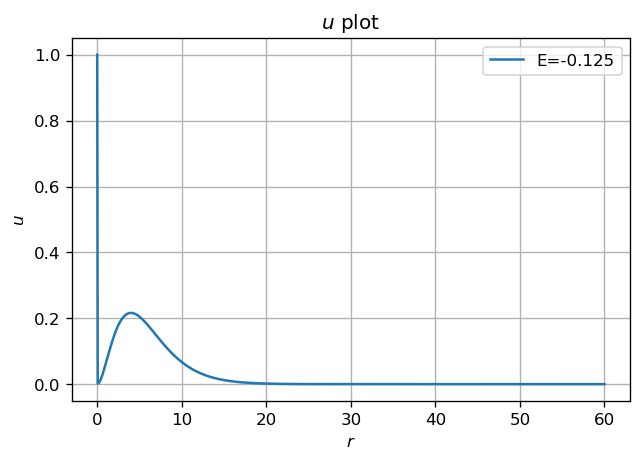

In [11]:
fig,ax = plt.subplots(1,1,figsize=(6,4),dpi=120)
ax.set_title('$u$ plot')
ax.set_xlabel('$r$')
ax.set_ylabel('$u$')
ax.plot(r,u_list[0],label='E=-0.125')
ax.legend()
ax.grid()

As for the situation when V(r)=1/r^4,the shooting method failed because the wave function oscillates rapidly.And thus we can't optimize the best Enenrgy by newton method or others,which will fall into the local minimal value or just can't converge.Even we applied the non-uniform grid to avoid this,it failed.The Schrödinger's equation is essentially a second-order equation, both the derivative and the second-order derivative in the vicinity of zero will repeatedly change signs.

以下内容都是测试，与本次作业无关。

使用odeint测试V2情况

/Users/pro/opt/anaconda3/envs/python37/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


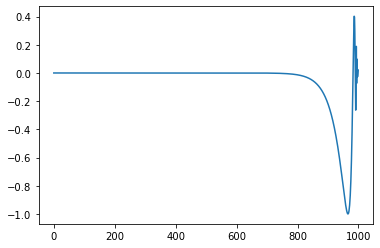

In [138]:
E=-1
l=0
r=np.linspace(20, 1e-4, 1000)
#r_exp=np.exp(r)
#print(r_exp)
option='V2'
result=odeint(diff2,[0,1e-4],r,args=(E,l,option))[:,0]
result=result/np.max(np.abs(result))
plt.plot(result)

使用solve_ivp测试V2

In [118]:
def diff(r,u,E,L,option='V1'):
    u1, u2 = u
    if option == 'V1':
        Vr = -1 / r + l * (l + 1) /2/ r ** 2
    elif option == 'V2':
        Vr = -1 / r ** 4 + l * (l + 1) /2/ r ** 2
    else:
        print("Wrong,option should be V1 or V2")
        exit()
    return [u2, 2*(Vr-E)*u1]

In [139]:
E=-0.8
l=0
sol=solve_ivp(diff,[20,1e-4],[0,1e-4],method='Radau',args=(E,l,option),dense_output=True)

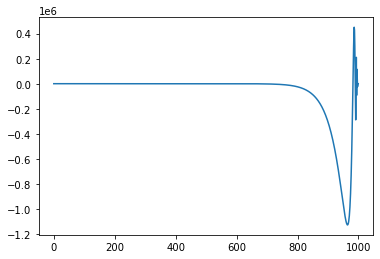

In [140]:
plt.plot(sol.sol(r)[0])

非均匀网格

In [141]:
def nonuniform(r,delta):
    rmax=np.max(r)
    jmax=len(r)
    rp=rmax/(np.exp(delta*jmax)-1)
    j=np.arange(1,jmax+1)
    rj=rp*(np.exp(delta*j)-1)
    return rj

In [146]:
def diff3(v,j,E,L,rp,delta,option='V1'):
    v1, v2 = v
    if option == 'V1':
        Vr = -1 / (rp*(np.exp(delta*j)-1)) + l * (l + 1) /2/ (rp*(np.exp(delta*j)-1)) ** 2
    elif option == 'V2':
        Vr = -1 / (rp*(np.exp(delta*j)-1)) ** 4 + l * (l + 1) /2/(rp*(np.exp(delta*j)-1)) ** 2
    else:
        print("Wrong,option should be V1 or V2")
        exit()
    return [v2, (0.25*delta**2-2*(E-Vr)*(rp*delta*np.exp(j*delta))**2)*v2]

In [154]:
r=np.linspace(20, 1e-4, 1000)
delta=0.005
E=-0.05
l=0
a=0
ui=1e-4
option='V1'
rj=nonuniform(r,delta)

In [155]:
jmax=len(r)
rp=rj[-1]/(np.exp(delta*jmax)-1)
j=np.arange(jmax+1,1,-1)

In [156]:
sol=solve_ivp(diff3,[1000,1],[0,1e-4],method='Radau',args=(E,l,rp,delta,option),dense_output=True)

TypeError: cannot unpack non-iterable float object

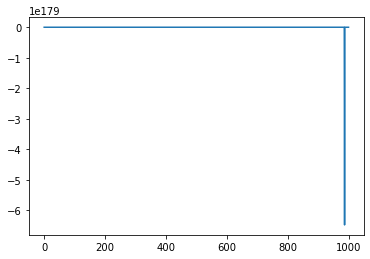

In [157]:
plt.plot(u)

In [158]:
result=odeint(diff3,[0,1e-4],j,args=(E,l,rp,delta,option))[:,0]

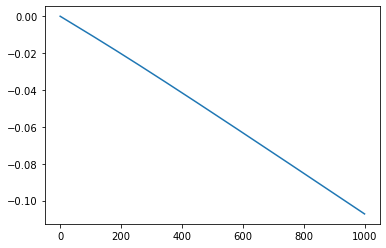

In [159]:
plt.plot(result)